Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with the bonus assignment - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn import metrics

In [2]:
np.random.seed(42)

In [3]:
digits = load_digits()
X, y = digits.data, digits.target

In [4]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)

**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

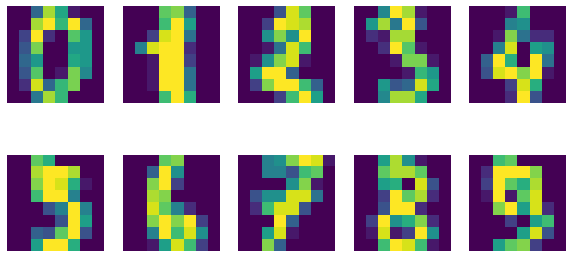

In [5]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for ax, image in zip(axes.flatten(), range(15)):
    ax.set_axis_off()
    ax.imshow(X[image].reshape((8, 8)), )

## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}|x_{i}-Z_{A(x_{i})}|^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [6]:
from sklearn.exceptions import NotFittedError
from numpy.random import RandomState

In [7]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=30, n_init=10, random_state=42):
        '''K-Means clustering.
        
        Args:
            n_clusters: int, default=2
                The number of clusters to be formed is also 
                the number of centroids to generate. 
            max_iter: int, default=300
                Maximum number of iterations of the k-means algorithm for a
                single run.
            n_init: int, default=10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of objective function.
            random_state: int, default=42
                Random state.
        '''
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = RandomState(seed=random_state)
        
    def calculate_distances_to_centroids(self, X, cluster_centers):
        """
        Returns (n, c) matrix where the element at position (i, j) 
        is the distance from i-th object to j-th centroid."""
        # <your code>
        nearest_clusters = []
        for x in range(X.shape[0]):
            nearest_clusters.append([np.linalg.norm(X[x]-cluster_centers[centr]) for centr in range(cluster_centers.shape[0])])

        return np.array(nearest_clusters)
    
    def update_centroids(self, X, nearest_clusters):
        """
        Returns numpy array of shape (n_clusters, n_features) - 
        new clusters that are found by averaging objects belonging 
        to the corresponding cluster."""
        # <your code>
        labels = nearest_clusters.argmin(axis=1)
        cluster_centers=np.zeros([self.n_clusters, X.shape[1]])
        for x in range(self.n_clusters):
            cluster_centers[x, :]  =np.mean(X[labels == x, :], axis=0)
        
        return cluster_centers, labels
        
    def fit(self, X):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        """
        assert X.shape[0] >= self.n_clusters
        # <your code>
        cent_history = np.zeros([self.n_init, self.n_clusters, X.shape[1]])
        self.init_error = []
        
        for n_init in range(self.n_init):  
            ind = self.random_state.permutation(X.shape[0])[:self.n_clusters]

            cluster_centers = X[ind]
            error=[]
            for n_iter in range(self.max_iter):
                nearest_clusters = self.calculate_distances_to_centroids(X, cluster_centers)
                cluster_centers, labels = self.update_centroids(X, nearest_clusters)
                error_iter = []
                for centr in range(cluster_centers.shape[0]):
                    error_iter.append(np.sum([np.sum((x-cluster_centers[centr])**2) for x in X[labels == centr]]))

                error.append(np.sum(error_iter))

                if len(error)>1 and (error[n_iter]>=error[n_iter-1]):
                    break

            cent_history[n_init, :, :] = cluster_centers
            self.init_error.append(error[-1])    
        self.cluster_centers_ = cent_history[np.argmin(self.init_error)]
           
        return self
            
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted cluster labels.
        """
        if hasattr(self, 'cluster_centers_'):
            # <your code>
            nearest_clusters = self.calculate_distances_to_centroids(X, self.cluster_centers_)
            labels = nearest_clusters.argmin(axis=1)
            return labels
        else: 
            raise NotFittedError("CustomKMeans instance is not fitted yet")

**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

In [8]:
kmeans = CustomKMeans(n_clusters=10)
kmeans.fit(X)

In [9]:
custom_kmeans_labels = kmeans.predict(X)
assert custom_kmeans_labels.shape == (1797,)

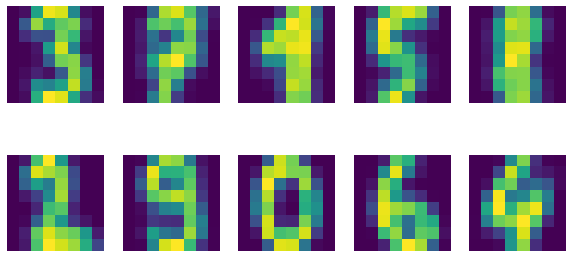

In [10]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for ax, image in zip(axes.flatten(), range(11)):
    ax.set_axis_off()
    ax.imshow(kmeans.cluster_centers_[image].reshape((8, 8)), )

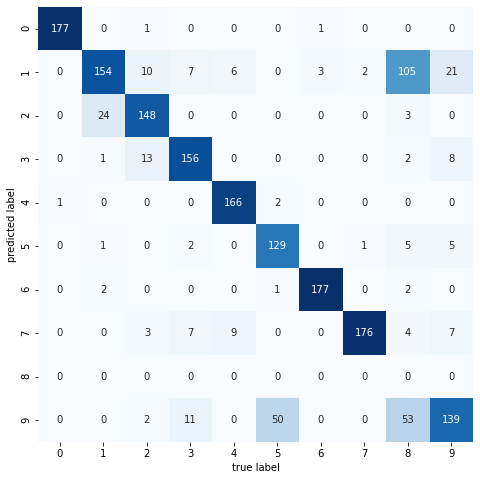

In [11]:
pred_y = np.zeros_like(custom_kmeans_labels)
for i in range(10):
    mask = (custom_kmeans_labels == i)
    pred_y[mask] = mode(y[mask])[0]
plt.figure(figsize=(8, 8))    
mat = metrics.confusion_matrix(y, pred_y)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

In [12]:
iter_num =[5, 10, 20, 50, 100]
init_num = [2, 5, 10, 20, 50, 100]
er_final = pd.DataFrame(columns=['n_init', 'max_iter', 'objective'])
for n in init_num:
    for i in iter_num:    
            km = CustomKMeans(n_clusters=10, max_iter=i, n_init=n)
            km.fit(X)
            er_final = er_final.append({'n_init':n, 'max_iter':i, 'objective':np.min(km.init_error)}, ignore_index=True)


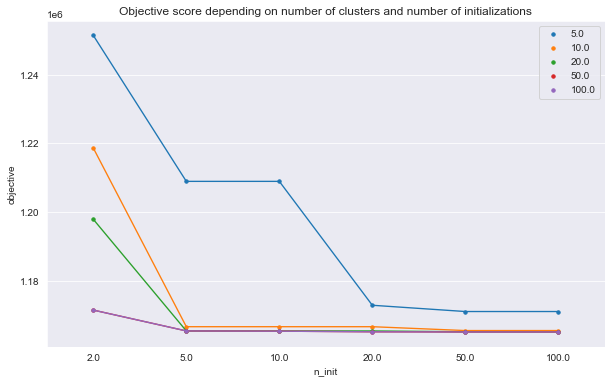

In [13]:
plt.figure(figsize=(10, 6)) 
sns.set_style("darkgrid")

sns.pointplot(x ='n_init', y='objective', hue='max_iter', data=er_final, scale=0.5);

plt.xlabel('n_init')
plt.ylabel('objective');
plt.legend()
plt.title("Objective score depending on number of clusters and number of initializations")
plt.show();    

In [14]:
er_final.sort_values(['objective', 'max_iter', 'n_init'])[:5]

,n_init,max_iter,objective
23,50.0,50.0,1.165134e+06
28,100.0,50.0,1.165134e+06
24,50.0,100.0,1.165134e+06
29,100.0,100.0,1.165134e+06
27,100.0,20.0,1.165149e+06


In [15]:
best_kmeans = CustomKMeans(n_clusters=10, max_iter=20, n_init=50)
best_kmeans.fit(X)

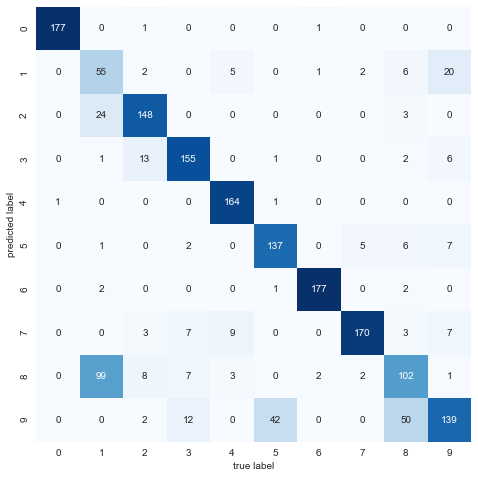

In [16]:
x_labels = best_kmeans.predict(X)
pred_y = np.zeros_like(x_labels)
for i in range(10):
    mask = (x_labels == i)
    pred_y[mask] = mode(y[mask])[0]
plt.figure(figsize=(8, 8))    
mat = metrics.confusion_matrix(y, pred_y)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

In [17]:
hier = AgglomerativeClustering(n_clusters=10).fit(X)
kmeans_sk = KMeans(n_clusters=10, random_state=42, n_init=20).fit(X)
hierarchical_labels = hier.labels_
kmeans_labels = kmeans_sk.labels_


In [18]:
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

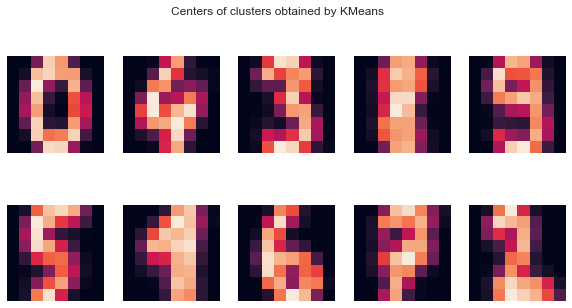

In [19]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
plt.suptitle("Centers of clusters obtained by KMeans")
for ax, image in zip(axes.flatten(), range(11)):
    ax.set_axis_off()
    ax.imshow(np.average(X[kmeans_labels==image], axis=0).reshape((8, 8)), )

plt.show()

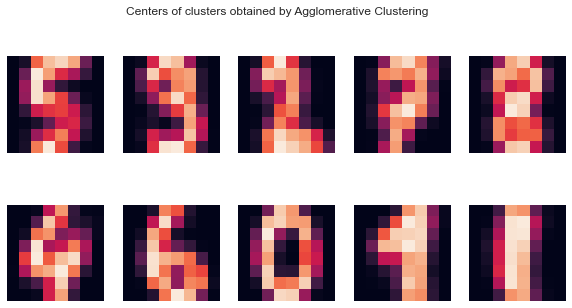

In [20]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for ax, image in zip(axes.flatten(), range(15)):
    ax.set_axis_off()
    ax.imshow(np.average(X[hierarchical_labels==image], axis=0).reshape((8, 8)))
plt.suptitle("Centers of clusters obtained by Agglomerative Clustering");


In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

**(0.75 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

In [21]:
n_clust = np.linspace(2, 20, 19, dtype=int)
kmeans_sil, agglo_sil = [], []
for k in n_clust:
    
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    kmeans_sil.append(metrics.silhouette_score(X, kmeans.labels_))
    agglo = AgglomerativeClustering(n_clusters=k).fit(X)
    agglo_sil.append(metrics.silhouette_score(X, agglo.labels_))


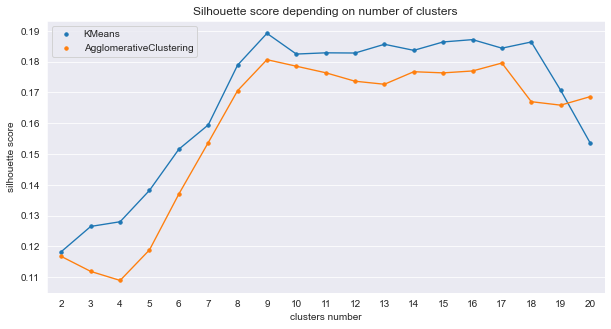

In [22]:
plt.figure(figsize=(10, 5)) 
sns.set_style("darkgrid")
sil_m = pd.DataFrame({'n_cluster':n_clust, 'KMeans':kmeans_sil, 'AgglomerativeClustering':agglo_sil}).melt(id_vars=['n_cluster'])

sns.pointplot(x =sil_m['n_cluster'], y=sil_m['value'], hue=sil_m['variable'], scale=0.5);

plt.xlabel('clusters number')
plt.ylabel('silhouette score');
plt.legend()
plt.title("Silhouette score depending on number of clusters")
plt.show();    

When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

In [23]:
n_clust = np.linspace(2, 20, 19, dtype=int)
kmeans_sil, agglo_sil = [], []
for k in n_clust:
    
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    kmeans_sil.append(metrics.v_measure_score(y, kmeans.labels_))
    agglo = AgglomerativeClustering(n_clusters=k).fit(X)
    agglo_sil.append(metrics.v_measure_score(y, agglo.labels_))

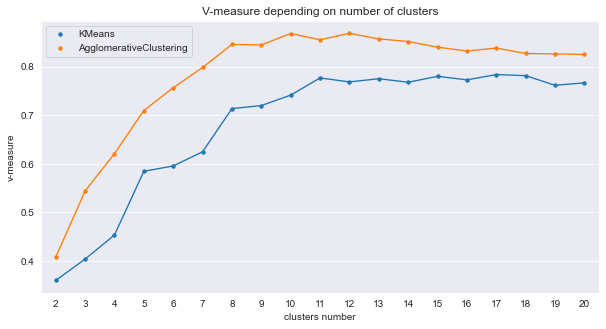

In [24]:
plt.figure(figsize=(10, 5)) 
sns.set_style("darkgrid")
sil_m = pd.DataFrame({'n_cluster':n_clust, 'KMeans':kmeans_sil, 'AgglomerativeClustering':agglo_sil}).melt(id_vars=['n_cluster'])

sns.pointplot(x =sil_m['n_cluster'], y=sil_m['value'], hue=sil_m['variable'], scale=0.5)

plt.xlabel('clusters number')
plt.ylabel('v-measure');
plt.legend()
plt.title("V-measure depending on number of clusters")
plt.show();  

## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

**(0.75 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

In [25]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

In [26]:
kmeans_orl = KMeans(n_clusters=10, random_state=42)
kmeans_orl.fit(X)

aggl_orl = AgglomerativeClustering(n_clusters=10)
aggl_orl.fit(X)
labels = [kmeans_orl.labels_, aggl_orl.labels_]

n_comp=[2, 5, 10, 20]
alg_name = ['K-means_SVD', 'Agglomerative_SVD', 'K-means',  'Agglomerative']
algorithms = []
algorithms.append(KMeans(n_clusters=10, random_state=42, n_init=20))
algorithms.append(AgglomerativeClustering(n_clusters=10))


data = []
varience_expl = []
for n in n_comp:   
    svd = TruncatedSVD(n_components=n, n_iter=7, random_state=42)
    X_red = svd.fit_transform(StandardScaler().fit_transform(X))
    varience_expl.append(svd.explained_variance_ratio_.sum())
    for i, algo in enumerate(algorithms):
        algo.fit(X_red)
        
        data.append(({
            'Features number': n,
            'Algorithm': f'{alg_name[i]}',
            'V-measure': metrics.v_measure_score(y, algo.labels_),
            'Silhouette': metrics.silhouette_score(X, algo.labels_)}))
        data.append(({
            'Features number': n,
            'Algorithm': f'{alg_name[i+2]}',
            'V-measure': metrics.v_measure_score(y, labels[i]),
            'Silhouette': metrics.silhouette_score(X, labels[i])}))

results = pd.DataFrame(data=data, columns=['Features number',
                                           'Algorithm', 'V-measure', 
                                           'Silhouette'],
                       )

In [27]:
results.sort_values(['V-measure', 'Silhouette'], ascending=False)[:5]

,Features number,Algorithm,V-measure,Silhouette
3,2,Agglomerative,0.868170,0.178497
7,5,Agglomerative,0.868170,0.178497
11,10,Agglomerative,0.868170,0.178497
15,20,Agglomerative,0.868170,0.178497
1,2,K-means,0.741468,0.182443


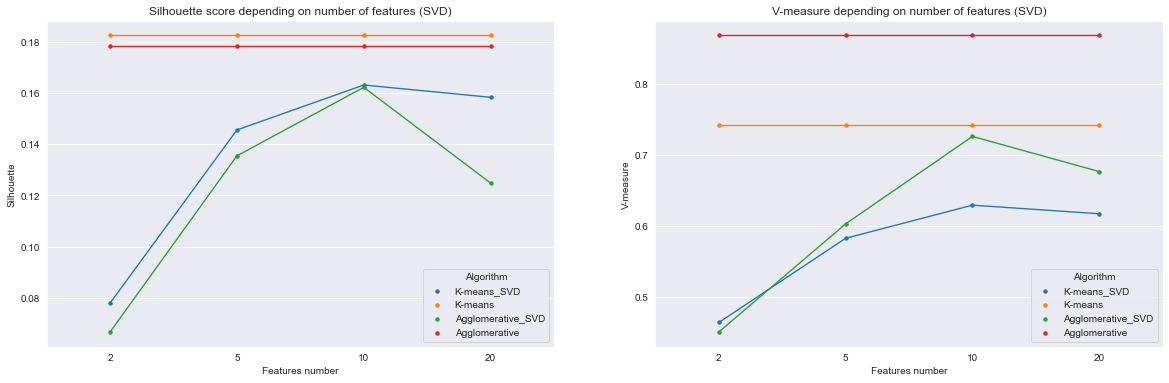

In [28]:
f,ax=plt.subplots(1,2,figsize=(20, 6))
sns.set_style("darkgrid")

sns.pointplot(x ='Features number', y='Silhouette', hue='Algorithm', data=results, ax=ax[0], scale=0.5);
ax[0].set_title('Silhouette score depending on number of features (SVD)')

sns.pointplot(x ='Features number', y='V-measure', hue='Algorithm', data=results, ax=ax[1], scale=0.5);
ax[1].set_title("V-measure depending on number of features (SVD)")


plt.show();  

Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

In [29]:
from sklearn.manifold import TSNE
import itertools

In [30]:
X_embedded = TSNE(n_components=2).fit_transform(X)

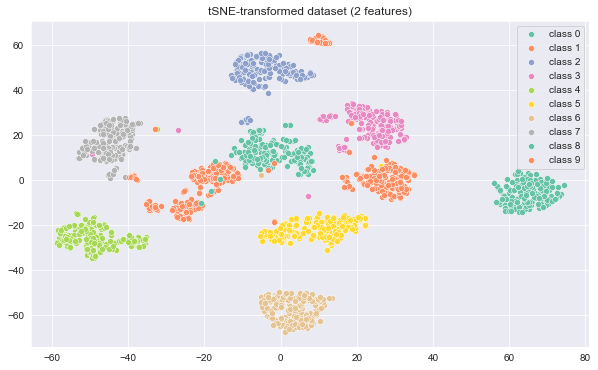

In [31]:

palette = itertools.cycle(sns.color_palette("Set2"))
plt.figure(figsize=(10, 6))
for i in range(0, 10):

        c = next(palette)
        sns.scatterplot(
            x=X_embedded[y==i, 0],
            y=X_embedded[y==i, 1],
            color=c,
            lw=2,
            label=f'class {i}',
        )
plt.title("tSNE-transformed dataset (2 features)")
plt.legend(loc="best", shadow=False, scatterpoints=1)

plt.show()

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

In [32]:
algo_names = ['K-means_tSNE', 'AgglomerativeClustering_tSNE', 'K-means', 'AgglomerativeClustering']
algorithms = []
algorithms.append(KMeans(n_clusters=10, random_state=1, n_init=50))
algorithms.append(AgglomerativeClustering(n_clusters=10))
data = []

for i, algo in enumerate(algorithms):
        algo.fit(X_embedded)
        data.append(({
            'Algorithm': algo_names[i],
            'V-measure': metrics.v_measure_score(y, algo.labels_),
            'Silhouette': metrics.silhouette_score(X, algo.labels_)}))
        algo.fit(X)
        data.append(({
            'Algorithm': algo_names[i+2],
            'V-measure': metrics.v_measure_score(y, algo.labels_),
            'Silhouette': metrics.silhouette_score(X, algo.labels_)}))

results_tsne = pd.DataFrame(data=data, columns=['Algorithm', 'V-measure', 'Silhouette'])

In [33]:
results_tsne.sort_values(['V-measure', 'Silhouette'], ascending=False)

,Algorithm,V-measure,Silhouette
0,K-means_tSNE,0.913780,0.163470
2,AgglomerativeClustering_tSNE,0.911147,0.164179
3,AgglomerativeClustering,0.868170,0.178497
1,K-means,0.746694,0.182624


**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

In [34]:
best_m = AgglomerativeClustering(n_clusters=10)
best_m.fit(X_embedded)

AgglomerativeClustering(n_clusters=10)

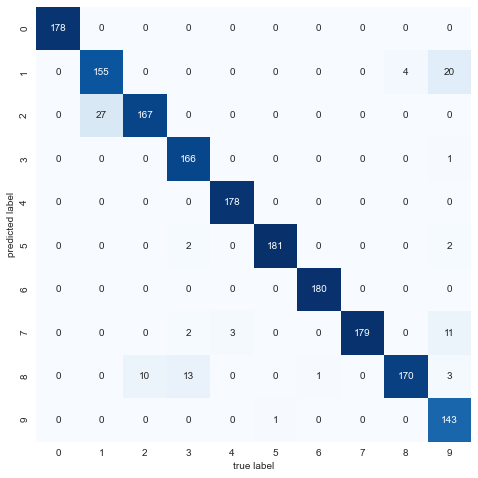

In [35]:
x_labels = best_m.labels_
pred_y = np.zeros_like(x_labels)
for i in range(10):
    mask = (x_labels == i)
    pred_y[mask] = mode(y[mask])[0]
plt.figure(figsize=(8, 8))    
mat = metrics.confusion_matrix(y, pred_y)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [36]:
print('V-measure', metrics.v_measure_score(y, best_m.labels_))
print('Silhouette', metrics.silhouette_score(X, best_m.labels_))

V-measure 0.9111471953871231
Silhouette 0.1641788047760139


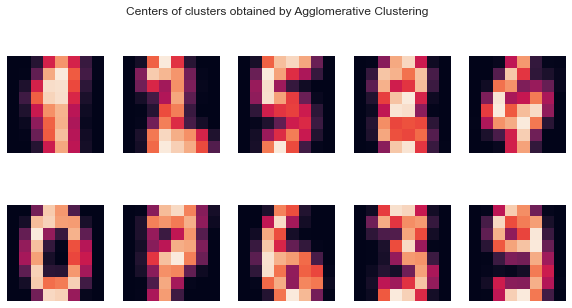

In [37]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for ax, image in zip(axes.flatten(), range(15)):
    ax.set_axis_off()
    ax.imshow(np.average(X[best_m.labels_==image], axis=0).reshape((8, 8)))
plt.suptitle("Centers of clusters obtained by Agglomerative Clustering");

## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

Выбор метода в первую очередь обусловлен типом данных. В нашем случае неплохие результаты показывают оба подхода, так как данные хорошо кластеризуются. В тоже время, при использовании различных метрик получаются противоречивые результаты, так, иерархическая кластеризация показывает более высокое значение V-measure, а KMeans - Silhouette. Настройки параметров моделей оказывают влияние на результаты, однако тенденции между моделями сохраняются.


**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.

Возможное решение - построить классификационную модель, например KNN, используя метки кластеров, полученых при иерархической кластеризации, как метки классов. После обучения модели оцениваем метриками классификации. \
Либо можно рассчитать для новых объектов расстояния до центров кластеров, полученных в обученной модели.

**(0.5 points)** Does dimensionality reduction improve clustering results?

В нашем случае tSNE позволяет улучшить результат, хотя обычно этот метод используется толкьо для визуализации. SVD показал себя хуже, вероятно это обусловленно как одинаковым вложением признаков в общую дисперсию, что не позволяет сократить размерность признаков значительно, так и нелинейностью связей между признаками. Однако, алгоритмы уменьшения размерности точно позволяют ускорить последующие алгритмы.

**(0.5 points)** How to evaluate the quality of dimensional reduction? Suggest at least 2 options.

1. Самый простой способ - сократить размерность до двух признаков и визуализировать результаты. Безусловно, это относительная оценка, однако она позволит понять насколько структурированными получаются выходные данные.
2. При наличии времни и возможности - можно сокращать размерность до различных значений и затем проверять полученные данные в других алгоритмах (например, кластеризации). Данный подход использовался нами. Главным ограничением подхода является необходимые вычислительные мощности и время. Можно также проводить данную оценку на части исходных данных.
3. Для отдельных методов сокращения размерности есть свои оценки. Например для PCA необходимо отслеживать долю сохранившейся дисперсии. Например, на наших данных уровень дисперсии 90% сохраняется при сокращении пространства с 64 до 20 признаков. В случае, если для достижения такого уровня сохранения дисперсии необходимо сохранять практически исходное пространство признаков, данный поход лучше не исползовать.

**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.

In [38]:
from sklearn.datasets import fetch_openml
X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True)

In [39]:
y_mnist = y_mnist.astype(int)

In [40]:
X_mnist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: float64(784)
memory usage: 418.7 MB


In [41]:
X_mnist.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,...,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.0,70000.0,70000.0,70000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.197414,0.099543,0.046629,0.016614,0.012957,0.001714,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.991206,4.256304,2.783732,1.561822,1.553796,0.320889,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0


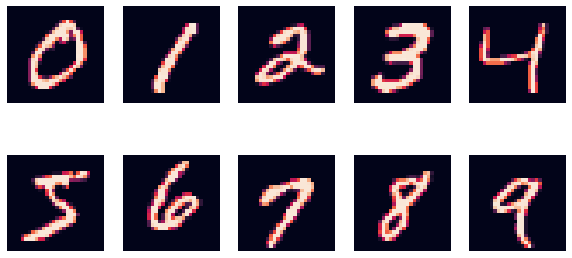

In [42]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for ax, image in zip(axes.flatten(), range(10)):
    ax.set_axis_off()
    ax.imshow(X_mnist.to_numpy()[y_mnist==image][0].reshape((28, 28)))

In [43]:
X_mnist_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_mnist)

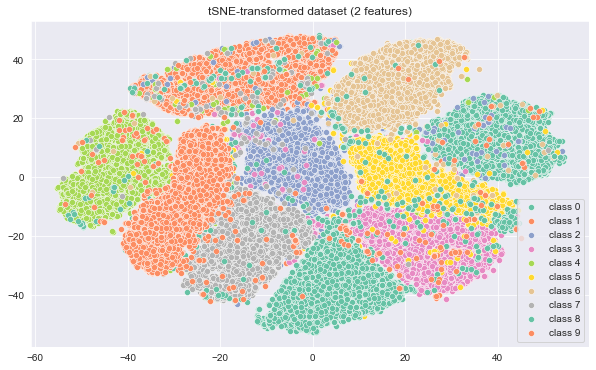

In [44]:

palette = itertools.cycle(sns.color_palette("Set2"))
plt.figure(figsize=(10, 6))
for i in range(0, 10):

        c = next(palette)
        sns.scatterplot(
            x=X_mnist_embedded[y_mnist==i, 0],
            y=X_mnist_embedded[y_mnist==i, 1],
            color=c,
            lw=2,
            label=f'class {i}',
        )
plt.title("tSNE-transformed dataset (2 features)")
plt.legend(loc="best", shadow=False, scatterpoints=1)

plt.show()

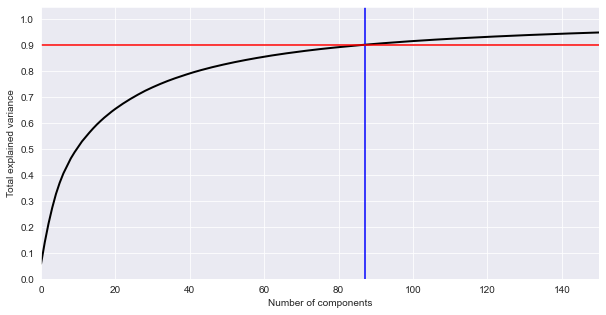

In [45]:
pca = TruncatedSVD(n_components=783, random_state=42).fit(X_mnist)
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 150)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(87, c='b')
plt.axhline(0.9, c='r')
plt.show();

In [46]:
from sklearn.neighbors import kneighbors_graph

In [47]:
#добавим connectivity, так как количество объектов большое и провести иерархическую классификацию по другому не получится

con_matr_100 = kneighbors_graph(X_mnist, n_neighbors=100)

In [48]:
algo_names = ['K-means', 'Agglomerative']
type_data = ['_tSNE', '', '_SVD']
svd = TruncatedSVD(n_components=87, n_iter=7, random_state=42)
X_mnist_red = svd.fit_transform(StandardScaler().fit_transform(X_mnist))
datasets = [X_mnist_embedded, X_mnist, X_mnist_red]
n_comp=[25, 60, 100, 200]
algorithms = []
algorithms.append(KMeans(n_clusters=10, random_state=42, n_init=20))
algorithms.append(AgglomerativeClustering(n_clusters=10, connectivity=con_matr_100))

varience_expl, data = [], []
for i, algo in enumerate(algorithms):
    for d in range(len(datasets)):
                algo.fit(datasets[d])
                data.append(({
                'Algorithm': algo_names[i]+type_data[d],
                'V-measure': metrics.v_measure_score(y_mnist, algo.labels_),
                'Silhouette': metrics.silhouette_score(X_mnist, algo.labels_)}))

results_tsne_mnist = pd.DataFrame(data=data, columns=['Algorithm', 'V-measure', 'Silhouette'])

In [49]:
results_tsne_mnist.sort_values(['V-measure', 'Silhouette'], ascending=False)

,Algorithm,V-measure,Silhouette
3,Agglomerative_tSNE,0.823555,0.041883
0,K-means_tSNE,0.743568,0.032235
4,Agglomerative,0.688995,0.025024
5,Agglomerative_SVD,0.674143,0.037984
1,K-means,0.499744,0.058692
2,K-means_SVD,0.430994,0.060073


In [50]:
best_m = AgglomerativeClustering(n_clusters=10, connectivity=con_matr_100)
best_m.fit(X_mnist_embedded)

AgglomerativeClustering(connectivity=<70000x70000 sparse matrix of type '<class 'numpy.float64'>'
	with 7000000 stored elements in Compressed Sparse Row format>,
                        n_clusters=10)

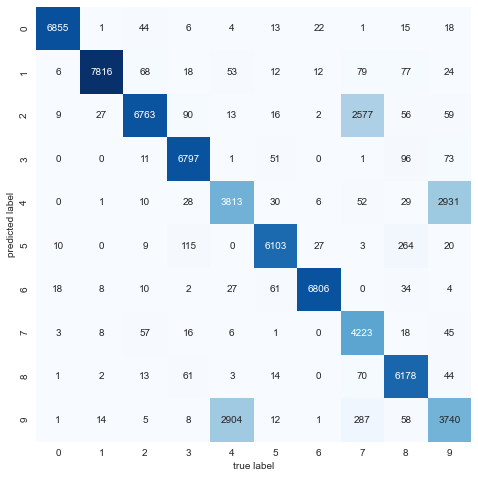

In [51]:
x_labels = best_m.labels_
pred_y = np.zeros_like(x_labels)
for i in range(10):
    mask = (x_labels == i)
    pred_y[mask] = mode(y_mnist[mask])[0]
plt.figure(figsize=(8, 8))    
mat = metrics.confusion_matrix(y_mnist, pred_y)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [52]:
print(metrics.classification_report(y_mnist, pred_y, zero_division=0))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6903
           1       0.96      0.99      0.97      7877
           2       0.70      0.97      0.81      6990
           3       0.97      0.95      0.96      7141
           4       0.55      0.56      0.56      6824
           5       0.93      0.97      0.95      6313
           6       0.98      0.99      0.98      6876
           7       0.96      0.58      0.72      7293
           8       0.97      0.91      0.94      6825
           9       0.53      0.54      0.53      6958

    accuracy                           0.84     70000
   macro avg       0.85      0.84      0.84     70000
weighted avg       0.86      0.84      0.84     70000



In [53]:
print('V-measure', metrics.v_measure_score(y_mnist, x_labels))
print('Silhouette', metrics.silhouette_score(X_mnist, x_labels))

V-measure 0.8235554701127556
Silhouette 0.04188316248860661


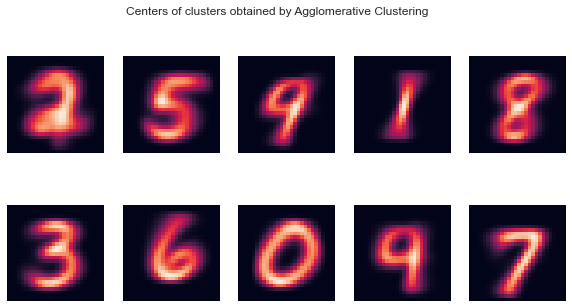

In [54]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for ax, image in zip(axes.flatten(), range(15)):
    ax.set_axis_off()
    ax.imshow(np.average(X_mnist.to_numpy()[x_labels==image], axis=0).reshape((28, 28)))
plt.suptitle("Centers of clusters obtained by Agglomerative Clustering");

Использовать AgglomerativeClustering на всех данных не удалось, так как размерность большая, однако даже с использованием  connectivity результаты весьма хорошие. Удалось идентифицировать все кластеры, однако для пар 2-7 и 4-9 наблюдается не очень хорошее разделение.

В целом, методы класстеризации показали себя очень мощными на данном типе задач.